Pre-Procesamiento de Imagenes:

Se importan librerías para remover los fondos de las imágenes, así como la redimensión de las mismas y colocar las imágenes en blanco y negro para su posterior normalización y etiquetado.

Se recorre la carpeta de Raw que contiene los datos crudos de las imágenes hasta recorrer las tres carpetas correspondientes (rock, paper,scissors). Primero remueve el fondo de la imagen, luego la convierte en escala de grises, la redimensiona a 30x20 px y finalmente guarda el resultado en la carpeta correspondiente, cambiando el nombre a processed_XXX (donde XXX es el nombre original del archivo).

In [ ]:
import os
from PIL import Image
from rembg import remove

# Ruta a la carpeta data/raw
raw_folder = "../data/raw"

# Recorre cada subcarpeta dentro de data/raw
for subfolder in os.listdir(raw_folder):
    subfolder_path = os.path.join(raw_folder, subfolder)
    
    # Verifica si es una carpeta
    if os.path.isdir(subfolder_path):
        print(f"Procesando carpeta: {subfolder}")
        
        # Recorre cada archivo en la subcarpeta
        for file_name in os.listdir(subfolder_path):
            file_path = os.path.join(subfolder_path, file_name)
            
            # Verifica si es una imagen
            if file_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                print(f"Procesando imagen: {file_name}")
                
                # Abre la imagen
                with Image.open(file_path) as img:
                    # Remueve el fondo
                    img_no_bg = remove(img)
                    
                    # Convierte a escala de grises
                    img_gray = img_no_bg.convert("L")
                    
                    # Redimensiona la imagen
                    img_resized = img_gray.resize((30, 20))
                    
                    # Guarda la imagen procesada
                    output_path = os.path.join(subfolder_path, f"processed_{file_name}")
                    img_resized.save(output_path)
                    print(f"Imagen procesada guardada en: {output_path}")




Normalización de los datos

In [ ]:
import os
import numpy as np
from PIL import Image
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor
import time  # Para medir el tiempo de ejecución

# Función para normalizar un lote de imágenes
def normalize_images(batch):
    for file_path in batch:
        try:
            # Abre la imagen
            with Image.open(file_path) as img:
                # Convierte la imagen a un array numpy y normaliza
                img_array = np.array(img) / 255.0
                
                # Convierte de nuevo a imagen y guarda
                normalized_img = Image.fromarray((img_array * 255).astype(np.uint8))
                normalized_img.save(file_path)
        except Exception as e:
            print(f"Error procesando {file_path}: {e}")

# Función para dividir una lista en lotes
def split_into_batches(file_list, batch_size):
    for i in range(0, len(file_list), batch_size):
        yield file_list[i:i + batch_size]

# Función para procesar una carpeta
def process_folder(subfolder):
    subfolder_path = os.path.join(processed_folder, subfolder)
    
    # Verifica si es una carpeta
    if os.path.isdir(subfolder_path):
        print(f"Procesando carpeta: {subfolder}")
        
        # Lista de imágenes en la carpeta
        file_list = [
            os.path.join(subfolder_path, file_name)
            for file_name in os.listdir(subfolder_path)
            if file_name.lower().endswith(('.png', '.jpg', '.jpeg'))
        ]
        
        # Divide las imágenes en lotes de 100
        batches = list(split_into_batches(file_list, 100))
        
        # Normaliza cada lote
        for batch in tqdm(batches, desc=f"Normalizando imágenes en {subfolder}", unit="lote"):
            normalize_images(batch)

# Usa ThreadPoolExecutor para procesar varias carpetas al mismo tiempo
if __name__ == "__main__":
    # Ruta a la carpeta data/processed
    processed_folder = "../data/processed"

    # Temporizador para medir el tiempo de ejecución
    start_time = time.time()

    # Lista de subcarpetas en data/processed
    subfolders = [subfolder for subfolder in os.listdir(processed_folder) if os.path.isdir(os.path.join(processed_folder, subfolder))]
    print(f"Inicialización completada en {time.time() - start_time:.2f} segundos")

    # Usa ThreadPoolExecutor para procesar carpetas en paralelo
    with ThreadPoolExecutor(max_workers=3) as executor:  # Cambia max_workers según el número de hilos que quieras usar
        list(tqdm(executor.map(process_folder, subfolders), total=len(subfolders), desc="Procesando carpetas"))

    print(f"Todas las carpetas procesadas en {time.time() - start_time:.2f} segundos")

División y Etiquetado de Imágenes en Conjuntos de Entrenamiento y Testeo

In [82]:
import os
import shutil
import pandas as pd
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm

def dividir_y_etiquetar(processed_folder, train_folder, test_folder, train_csv_path, test_csv_path, test_size=0.3):
    """
    Divide las imágenes directamente desde las carpetas de processed en entrenamiento y testeo,
    las mueve a sus respectivas carpetas y genera los CSVs correspondientes.
    """
    # Diccionario para almacenar rutas y etiquetas
    data = []

    # Recorre cada subcarpeta dentro de processed_folder
    label_map = {"rock": 0, "paper": 1, "scissors": 2}
    # label_map = {"rock": 0,"scissors": 2,}
    subfolders = [subfolder for subfolder in os.listdir(processed_folder) if os.path.isdir(os.path.join(processed_folder, subfolder))]
    for subfolder in tqdm(subfolders, desc="Procesando subcarpetas"):
        subfolder_path = os.path.join(processed_folder, subfolder)
        label = label_map.get(subfolder.lower(), -1)
        if label == -1:
            print(f"Carpeta desconocida: {subfolder}. Ignorando...")
            continue

        # Recorre cada archivo en la subcarpeta
        file_list = [os.path.join(subfolder_path, file_name) for file_name in os.listdir(subfolder_path) if file_name.lower().endswith(('.png', '.jpg', '.jpeg'))]
        for file_path in file_list:
            data.append({"path": file_path, "label": label})

    # Convierte los datos a un DataFrame
    df = pd.DataFrame(data)

    # Divide los datos en entrenamiento y testeo
    train_df, test_df = train_test_split(df, test_size=test_size, random_state=42, stratify=df["label"])

    # Crea las carpetas de destino
    os.makedirs(train_folder, exist_ok=True)
    os.makedirs(test_folder, exist_ok=True)

    # Función para mover imágenes y generar rutas relativas
    def mover_imagenes_y_generar_csv(df, target_folder, csv_path, base_folder):
        registros = []
        for _, row in tqdm(df.iterrows(), total=len(df), desc=f"Procesando {target_folder}"):
            label_folder = os.path.join(target_folder, str(row["label"]))
            os.makedirs(label_folder, exist_ok=True)
            # Copiar la imagen a la carpeta correspondiente
            dest_path = os.path.join(label_folder, os.path.basename(row["path"]))
            shutil.copy(row["path"], dest_path)
            # Generar ruta relativa con el prefijo ../data/
            relative_path = os.path.relpath(dest_path, base_folder)
            registros.append({"path": f"../data/{relative_path.replace(os.sep, '/')}", "label": row["label"]})
        # Guardar el CSV
        pd.DataFrame(registros).to_csv(csv_path, index=False)

    # Procesar imágenes de entrenamiento
    mover_imagenes_y_generar_csv(train_df, train_folder, train_csv_path, os.path.dirname(train_csv_path))

    # Procesar imágenes de testeo
    mover_imagenes_y_generar_csv(test_df, test_folder, test_csv_path, os.path.dirname(test_csv_path))

    print(f"Conjunto de entrenamiento guardado en: {train_csv_path}")
    print(f"Conjunto de testeo guardado en: {test_csv_path}")


# Rutas de las carpetas y archivos
processed_folder = "../data/processed"
train_folder = "../data/training"
test_folder = "../data/test"
train_csv_path = "../data/training_labels.csv"
test_csv_path = "../data/test_labels.csv"

# Divide y etiqueta directamente
dividir_y_etiquetar(processed_folder, train_folder, test_folder, train_csv_path, test_csv_path)

Procesando subcarpetas:   0%|          | 0/3 [00:00<?, ?it/s]

Procesando ../data/training:   0%|          | 0/1531 [00:00<?, ?it/s]

Procesando ../data/test:   0%|          | 0/657 [00:00<?, ?it/s]

Conjunto de entrenamiento guardado en: ../data/training_labels.csv
Conjunto de testeo guardado en: ../data/test_labels.csv


Muestra de algunos datos de entrenamiento

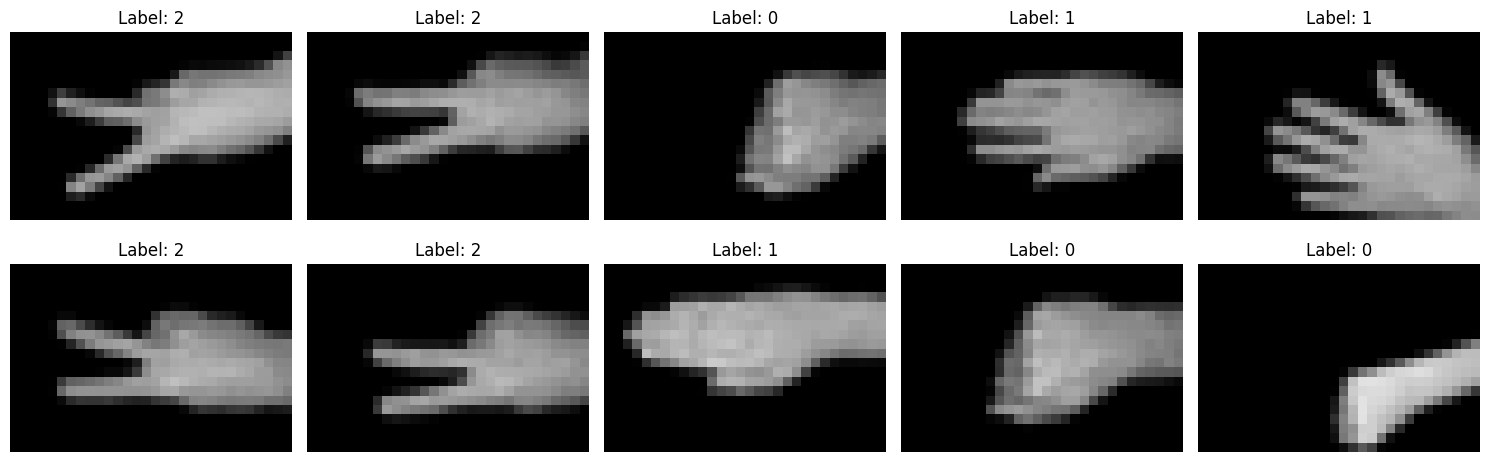

In [41]:
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img

# Ruta al archivo CSV de entrenamiento
train_csv_path = "../data/training_labels.csv"

# Cargar el archivo CSV
train_df = pd.read_csv(train_csv_path)

# Seleccionar las primeras 10 imágenes del conjunto de entrenamiento
sample_images = train_df.head(10)

# Crear una figura para mostrar las imágenes
plt.figure(figsize=(15, 5))

for i, row in enumerate(sample_images.itertuples(), start=1):
    # Cargar la imagen desde la ruta
    img = load_img(row.path)
    
    # Mostrar la imagen
    plt.subplot(2, 5, i)  # Crear una cuadrícula de 2 filas y 5 columnas
    plt.imshow(img, cmap="gray")  # Mostrar en escala de grises si es necesario
    plt.title(f"Label: {row.label}")
    plt.axis("off")  # Ocultar los ejes

# Mostrar todas las imágenes
plt.tight_layout()
plt.show()

Creación del Modelo

In [267]:
#Creacion de modelo de redes neuronales convolucionales
import tensorflow as tf


model = tf.keras.models.Sequential([
    # tf.keras.layers.Conv2D(64, (3,3), input_shape=(20, 30, 1), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    #  tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

    # tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    # tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

    tf.keras.layers.Flatten(input_shape=(20, 30, 1)), #aplanamiento de las entradas, estas son de 20x30px en escala de grises (1)
    
    tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.3),

    # tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    # tf.keras.layers.Dropout(0.3),

    tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.3),

    # tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    # tf.keras.layers.Dropout(0.3),

    tf.keras.layers.Dense(64, activation='sigmoid', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.3),

    tf.keras.layers.Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.3),

    tf.keras.layers.Dense(3, activation='softmax')  
])


# Compilación del modelo
model.compile(
    optimizer="adam",
    loss= tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

c:\Users\sebas\Desktop\Universidad\Semestre 2025-25\IA\Proyecto 1\Piedra-Papel-Tijera-IA\venv\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Entrenamiento del modelo

In [268]:
import os
import tensorflow as tf
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
#from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau


# model = load_model("../models/piedra_papel_tijera_model.keras")

# Ruta al archivo CSV de entrenamiento
train_csv_path = "../data/training_labels.csv"

# Cargar el archivo CSV
train_df = pd.read_csv(train_csv_path)

# Convertir las etiquetas a cadenas
train_df['label'] = train_df['label'].astype(str)

# Dimensiones de las imágenes
IMG_HEIGHT = 20
IMG_WIDTH = 30

# Entrenar el modelo usando el generador
EPOCHS = 100

# Crear un generador de datos con aumentos
datagen = ImageDataGenerator(
    rotation_range=30,         # Rotar las imágenes hasta 30 grados
    width_shift_range=0.2,     # Desplazar horizontalmente hasta un 20%
    height_shift_range=0.2,    # Desplazar verticalmente hasta un 20%
    shear_range=0.2,           # Aplicar transformaciones de corte
    zoom_range=0.2,            # Hacer zoom dentro de un rango del 20%
    horizontal_flip=True,      # Voltear horizontalmente las imágenes
    fill_mode='nearest',        # Cómo rellenar los píxeles vacíos tras las transformaciones
    validation_split=0.2        
    # rescale=1.0/255.0          # Normalizar los valores de los píxeles entre 0 y 1
)

#Validación cruzada
train_generator = datagen.flow_from_dataframe(
    dataframe=train_df,
    directory="../data/",
    x_col="path",
    y_col="label",
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    color_mode="grayscale",
    class_mode="sparse",
    batch_size=64,
    shuffle=True,
    subset="training",  # Subconjunto de entrenamiento
)

val_generator = datagen.flow_from_dataframe(
    dataframe=train_df,
    directory="../data/",
    x_col="path",
    y_col="label",
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    color_mode="grayscale",
    class_mode="sparse",
    batch_size=64,
    shuffle=True,
    subset="validation"  # Subconjunto de validación
)

#Detención temprana
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,  # Detener después de 5 épocas sin mejora
    restore_best_weights=True
)

# Configurar ReduceLROnPlateau
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',  # Monitorea la pérdida en validación
    factor=0.5,          # Reduce el learning rate a la mitad
    patience=3,          # Espera 3 épocas sin mejora
    min_lr=1e-6,         # Learning rate mínimo
    verbose=1            # Mensajes en consola
)

print("Entrenando el modelo con aumento de datos...")

history = model.fit(
    train_generator,
    validation_data=val_generator,
    callbacks=[early_stopping, reduce_lr],
    epochs=EPOCHS
)

print("Modelo entrenado con éxito.")

# Crear la carpeta 'models' si no existe

models_folder = "../models"
os.makedirs(models_folder, exist_ok=True)

# Guardar el modelo en formato TensorFlow SavedModel
model_save_path = os.path.join(models_folder, "piedra_papel_tijera_model.keras")
model.save(model_save_path)

print(f"Modelo guardado en: {model_save_path}")

Found 1225 validated image filenames belonging to 3 classes.
Found 306 validated image filenames belonging to 3 classes.
Entrenando el modelo con aumento de datos...
Epoch 1/100


c:\Users\sebas\Desktop\Universidad\Semestre 2025-25\IA\Proyecto 1\Piedra-Papel-Tijera-IA\venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 103ms/step - accuracy: 0.3814 - loss: 2.2544 - val_accuracy: 0.4052 - val_loss: 2.0251 - learning_rate: 0.0010
Epoch 2/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 98ms/step - accuracy: 0.4085 - loss: 2.1011 - val_accuracy: 0.4379 - val_loss: 1.8703 - learning_rate: 0.0010
Epoch 3/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 84ms/step - accuracy: 0.4707 - loss: 1.8710 - val_accuracy: 0.4608 - val_loss: 1.7458 - learning_rate: 0.0010
Epoch 4/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 85ms/step - accuracy: 0.4898 - loss: 1.7949 - val_accuracy: 0.5229 - val_loss: 1.6325 - learning_rate: 0.0010
Epoch 5/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - accuracy: 0.5163 - loss: 1.6707 - val_accuracy: 0.5425 - val_loss: 1.5815 - learning_rate: 0.0010
Epoch 6/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step - accuracy: 0.5344 - loss: 1.6677 - val_accuracy: 0.6078 - val_loss: 1.4968 - learning_rate: 0.0010
Epoch 7/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 0.6288 - loss: 1.5521 - val_accurac

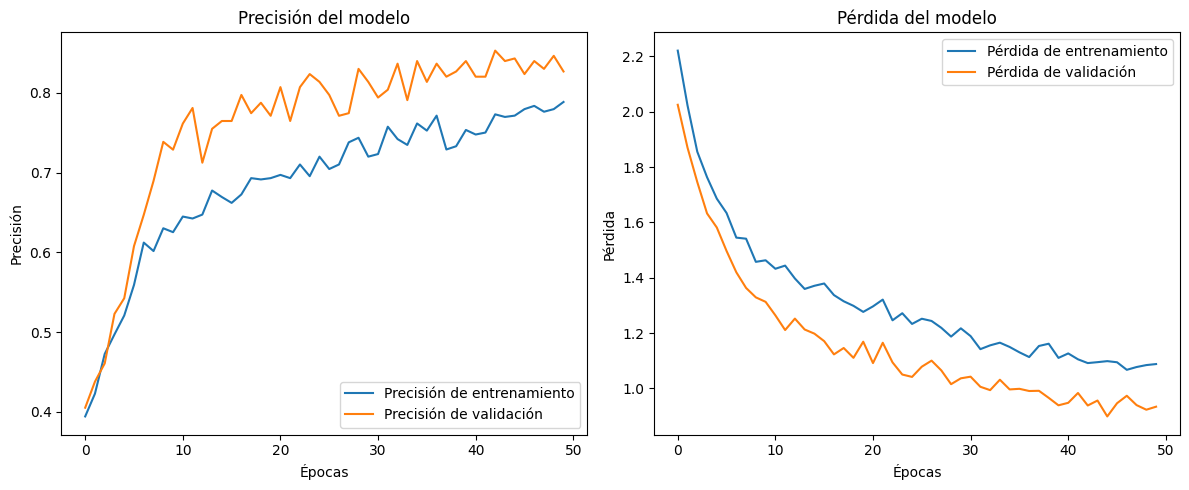

In [269]:
import matplotlib.pyplot as plt

# Graficar la precisión del modelo
plt.figure(figsize=(12, 5))

# Precisión
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Precisión de entrenamiento')
if 'val_accuracy' in history.history:
    plt.plot(history.history['val_accuracy'], label='Precisión de validación')
plt.title('Precisión del modelo')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()

# Pérdida
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Pérdida de entrenamiento')
if 'val_loss' in history.history:
    plt.plot(history.history['val_loss'], label='Pérdida de validación')
plt.title('Pérdida del modelo')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()

# Mostrar las gráficas
plt.tight_layout()
plt.show()

Prueba de testeo

In [270]:
import tensorflow as tf
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Ruta al archivo CSV de test
test_csv_path = "../data/test_labels.csv"

# Cargar el archivo CSV
test_df = pd.read_csv(test_csv_path)

# Dimensiones de las imágenes
IMG_HEIGHT = 20
IMG_WIDTH = 30

# Cargar imágenes y etiquetas desde el CSV
X_test = np.array([
    img_to_array(load_img(row.path, target_size=(IMG_HEIGHT, IMG_WIDTH), color_mode="grayscale"))
    for row in test_df.itertuples()
])
y_test = test_df['label'].values  # Etiquetas

# Evaluar el modelo
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=1)

print(f"Pérdida en el conjunto de test: {test_loss:.4f}")
print(f"Precisión en el conjunto de test: {test_accuracy:.4f}")



21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9246 - loss: 0.8118
Pérdida en el conjunto de test: 0.8049
Precisión en el conjunto de test: 0.9285


F1-score y recall

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
F1-Score: 0.9279
Precisión: 0.9282
Recall: 0.9285

Reporte de clasificación:
              precision    recall  f1-score   support

        Rock       0.95      0.99      0.97       218
       Paper       0.93      0.87      0.90       214
    Scissors       0.91      0.92      0.92       225

    accuracy                           0.93       657
   macro avg       0.93      0.93      0.93       657
weighted avg       0.93      0.93      0.93       657


Matriz de confusión:
[[216   2   0]
 [  8 186  20]
 [  4  13 208]]


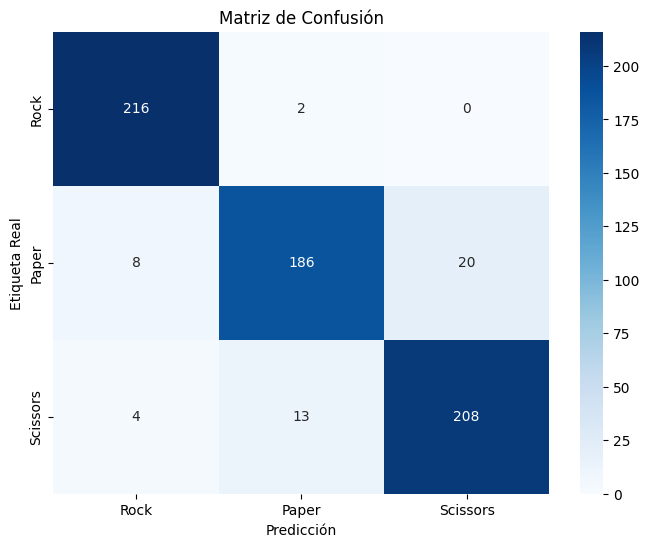

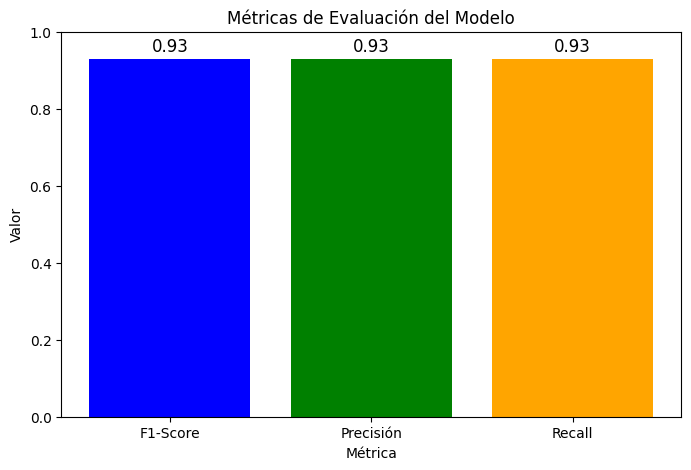

In [271]:
from sklearn.metrics import classification_report, confusion_matrix, f1_score, precision_score, recall_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns  # Para graficar la matriz de confusión

# Realizar predicciones en el conjunto de test
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convertir probabilidades a clases

# Calcular F1-score, precisión y recall
f1 = f1_score(y_test, y_pred_classes, average='weighted')
precision = precision_score(y_test, y_pred_classes, average='weighted')
recall = recall_score(y_test, y_pred_classes, average='weighted')

# Imprimir métricas
print(f"F1-Score: {f1:.4f}")
print(f"Precisión: {precision:.4f}")
print(f"Recall: {recall:.4f}")

# Reporte de clasificación detallado
print("\nReporte de clasificación:")
print(classification_report(y_test, y_pred_classes, target_names=["Rock", "Paper", "Scissors"]))

# Matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred_classes)
print("\nMatriz de confusión:")
print(conf_matrix)

# Graficar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Rock", "Paper", "Scissors"], yticklabels=["Rock", "Paper", "Scissors"])
plt.title("Matriz de Confusión")
plt.xlabel("Predicción")
plt.ylabel("Etiqueta Real")
plt.show()

# Graficar métricas
metrics = ['F1-Score', 'Precisión', 'Recall']
values = [f1, precision, recall]

plt.figure(figsize=(8, 5))
plt.bar(metrics, values, color=['blue', 'green', 'orange'])
plt.ylim(0, 1)  # Escala de 0 a 1
plt.title('Métricas de Evaluación del Modelo')
plt.ylabel('Valor')
plt.xlabel('Métrica')
for i, v in enumerate(values):
    plt.text(i, v + 0.02, f"{v:.2f}", ha='center', fontsize=12)
plt.show()

Procesando imagen: AjwddXm0ttm7Ts5J.png de la carpeta paper
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step
Probabilidades de predicción:
Rock: 0.0093
Paper: 0.1089
Scissors: 0.8818


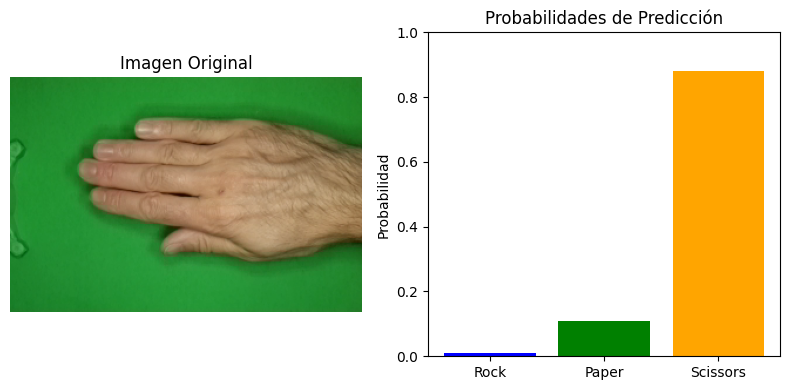

In [274]:
# Bloque para probar una imagen específica de una subcarpeta en raw
import os
from PIL import Image
from rembg import remove
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import random

# Ruta a la carpeta raw y al modelo guardado
raw_folder = "../data/raw"
model_path = "../models/piedra_papel_tijera_model.keras"

# Obtener una lista de subcarpetas (rock, paper, scissors)
subfolders = [subfolder for subfolder in os.listdir(raw_folder) if os.path.isdir(os.path.join(raw_folder, subfolder))]
if not subfolders:
    print("No se encontraron subcarpetas en la carpeta raw.")
else:
    # Mezclar las subcarpetas para obtener una diferente cada vez
    random.shuffle(subfolders)
    selected_subfolder = subfolders[0]
    subfolder_path = os.path.join(raw_folder, selected_subfolder)

    # Obtener una lista de imágenes en la subcarpeta seleccionada
    images = [file for file in os.listdir(subfolder_path) if file.lower().endswith(('.png', '.jpg', '.jpeg'))]
    if not images:
        print(f"No se encontraron imágenes en la subcarpeta {selected_subfolder}.")
    else:
        # Mezclar las imágenes para obtener una diferente cada vez
        random.shuffle(images)
        selected_image = images[0]
        image_path = os.path.join(subfolder_path, selected_image)

        # Cargar y procesar la imagen
        with Image.open(image_path) as img:
            print(f"Procesando imagen: {selected_image} de la carpeta {selected_subfolder}")

            # Remover el fondo
            img_no_bg = remove(img)

            # Convertir a escala de grises
            img_gray = img_no_bg.convert("L")

            # Redimensionar la imagen
            img_resized = img_gray.resize((30, 20))

            # Normalizar la imagen
            img_array = np.array(img_resized) / 255.0
            img_normalized = np.expand_dims(img_array, axis=(0, -1))  # Expandir dimensiones para el modelo

            # Cargar el modelo
            model = tf.keras.models.load_model(model_path)

            # Realizar la predicción
            predictions = model.predict(img_normalized)
            class_names = ["Rock", "Paper", "Scissors"]

            # Mostrar los resultados
            print("Probabilidades de predicción:")
            for i, class_name in enumerate(class_names):
                print(f"{class_name}: {predictions[0][i]:.4f}")

            # Graficar la imagen original y las probabilidades
            plt.figure(figsize=(8, 4))

            # Imagen original
            plt.subplot(1, 2, 1)
            plt.imshow(img)
            plt.title("Imagen Original")
            plt.axis("off")

            # Probabilidades de predicción
            plt.subplot(1, 2, 2)
            plt.bar(class_names, predictions[0], color=["blue", "green", "orange"])
            plt.title("Probabilidades de Predicción")
            plt.ylabel("Probabilidad")
            plt.ylim(0, 1)

            plt.tight_layout()
            plt.show()
